In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from itertools import product

In [2]:
class American_put_option():
    def __init__(self, p0, d, seed=1):
        np.random.seed(seed)
        self.lower = 60
        self.upper = 160
        self.p0 = p0
        self.A = [0, 1] # a=0 is not exercising, a=1 is exercising
        self.K = 100
        self.epsilon = 5
        self.c = [1.02, 0.98]
        self.s0 = np.random.uniform(self.K - self.epsilon, self.K + self.epsilon, 1)
        self.d = d
        self.Delta = (self.upper - self.lower) / d
        self.anchor = [80 + x * self.Delta for x in range(d)]

    def reset(self):
        self.S = [self.s0]
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory with respect to a=0
        self.current_state = self.s0  # reset the current state to initial state

    def phi(self, s):
        phi = [max(0, (1 - np.abs(s - si) / self.Delta)[0]) for si in self.anchor]    
        #print(phi)
        return np.array(phi)
    
    def add_state(self, s):
        self.S.append(s)
        self.current_state = s

    def update_state(self):
        idx = np.random.choice([0, 1], p = [self.p0, 1 - self.p0])
        sprime = self.current_state * self.c[idx]
        return sprime
    
    def next_state(self, a):
        if a == 1:
            next_state = np.array([99999])
            self.add_state(next_state)
            return next_state
        else:
            next_state = self.update_state()
            # next_state = max(self.lower, next_state)
            # next_state = min(self.upper, next_state)
            self.add_state(next_state)
            return next_state
    
    def generate_reward(self, a):
        if a == 0:
            reward = 0
            self.R.append(reward)
            return reward
        else:
            reward = max(0, (self.K - self.current_state)[0])
            self.R.append(reward)
            return reward
    
    def step(self, a):
        self.A.append(a)
        phi = self.phi(self.current_state)
        self.feature.append(phi)
        self.generate_reward(a)
        self.next_state(a)
        self.h += 1


In [11]:
def Offline_Dataset_Collection(sample_size, env, seed=1):
    np.random.seed(seed)
    H = 20
    history = {'S':[], 'A':[], 'R':[], 'phi':[]}    
    epoch = sample_size
    for t in range(epoch):
        env.reset()
        for h in range(H):
            action = 0
            env.step(action)
        # log the trajectory
        history['S'].append(env.S)
        history['A'].append(env.A)
        history['R'].append(env.R)
        history['phi'].append(env.feature)
        #history['k'] += 1
    return history

Offline_Dataset = Offline_Dataset_Collection(1000, American_put_option(0.5, 20))
print(Offline_Dataset['A'])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 

In [4]:
class LSVI_LCB():
    def __init__(self, d, beta, H, lam, dataset, Rho):
        self.lam = lam
        self.H = H
        self.d = d
        self.K = len(dataset['S'])
        self.beta = beta
        self.w = [np.zeros(self.d) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(self.d)) for _ in range(self.H)]
        self.dataset = dataset

    def get_action(self, phi, h, current_state):
        #print(self.K - current_state)
        Q_exercising = max([0], self.K - current_state)
        #print(Q_exercising)
        Q_not_exercising = self.get_Q_func(phi, h)
        Q = [Q_not_exercising, Q_exercising[0]]
        #print(Q)
        return np.argmax(Q)

    def get_Q_func(self, phi, h):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
        Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
        return Q_h
    
    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] #initialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.K):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            #  calculate w_h
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            w_h = np.zeros(self.d)
            if h == self.H - 1:
                w_h = np.zeros(self.d)
            else:
                for tau in range(self.K):
                    phi_tau_h = self.dataset['phi'][tau][h]
                    phi_tau_h_plus_one = self.dataset['phi'][tau][h+1]
                    s_tau_h_plus_one = self.dataset['S'][tau][h+1]
                    Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one, h+1), max(0, (self.K - s_tau_h_plus_one)[0])]
                    V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
                    w_h += Lambda_h_inverse @ (phi_tau_h * (V_tau_h_plus_one))
            self.w[h] = w_h

class DR_LSVI_LCB():
    def __init__(self, d, beta, H, lam, dataset, Rho):
        self.lam = lam
        self.H = H
        self.d = d
        self.K = len(dataset['S'])
        self.beta = beta
        self.w = [np.zeros(self.d) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(self.d)) for _ in range(self.H)]
        self.Rho = Rho
        self.dataset = dataset

    def get_action(self, phi, h, current_state):
        Q_exercising = max(0, (self.K - current_state)[0])
        Q_not_exercising = self.get_Q_func(phi, h)
        Q = [Q_not_exercising, Q_exercising]
        return np.argmax(Q)

    def get_Q_func(self, phi, h):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
        Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
        return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(self.d)
        Phi_h = np.zeros((0, self.d))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.K):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi'][tau][h+1]
            s_tau_h_plus_one = self.dataset['S'][tau][h+1]
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one, h+1), max(0, (self.K - s_tau_h_plus_one)[0])]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(self.d):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
                return -z[i] + rho * alpha
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(0, self.H)])
            nu_h[i] = - result.fun
        return nu_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.K):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(self.d)
            nu_h = np.zeros(self.d)
            if h == self.H - 1:
                w_h = np.zeros(self.d)
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho)
                w_h = nu_h
            self.w[h] = w_h
            
class meta_algorithm():
    def __init__(self, d, beta, H, lam, dataset, Rho):
        self.lam = lam
        self.H = H
        self.d = d
        self.K = len(dataset['S'])
        self.beta = beta
        self.w = [np.zeros(self.d) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(self.d)) for _ in range(self.H)]
        self.Rho = Rho
        self.dataset = dataset

    def get_action(self, phi, h, current_state):
        Q_exercising = max(0, (self.K - current_state)[0])
        Q_not_exercising = self.get_Q_func(phi, h)
        Q = [Q_not_exercising, Q_exercising]
        return np.argmax(Q)

    def get_Q_func(self, phi, h):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
        Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
        return Q_h

    def get_nu_h(self, h, rho):
        pass

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.K):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(self.d)
            nu_h = np.zeros(self.d)
            if h == self.H - 1:
                w_h = np.zeros(self.d)
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho)
                w_h = nu_h
            self.w[h] = w_h      
                
class SRPVI_TV(meta_algorithm):
    def __init__(self, d, beta, H, lam, dataset, Rho):
        super().__init__(d, beta, H, lam, dataset, Rho)

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(self.d)
        Phi_h = np.zeros((0, self.d))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.K):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi'][tau][h+1]
            s_tau_h_plus_one = self.dataset['S'][tau][h+1]
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one, h+1), max(0, (self.K - s_tau_h_plus_one)[0])]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        alpha = np.min(V_h_plus_one) + rho
        w_h = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
        return w_h
    
class SRPVI_KL(meta_algorithm):
    def __init__(self, d, beta, H, lam, dataset, Rho):
        super().__init__(d, beta, H, lam, dataset, Rho)

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(self.d)
        Phi_h = np.zeros((0, self.d))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.K):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi'][tau][h+1]
            s_tau_h_plus_one = self.dataset['S'][tau][h+1]
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one, h+1), max(0, (self.K - s_tau_h_plus_one)[0])]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        w_h = Lambda_h_inverse @ Phi_h.T @ np.exp(-V_h_plus_one / rho)
        #print(w_h)
        return - rho * np.log(np.maximum(w_h, np.exp(-self.H/rho)))


In [5]:
def train_once_LSVI(d, beta, H, lam, dataset):
    agent = LSVI_LCB(d, beta, H, lam, dataset)
    agent.update_Q()
    return agent

def train_once_DR(d, beta, H, lam, dataset, Rho):
    agent = DR_LSVI_LCB(d, beta, H, lam, dataset, Rho)
    agent.update_Q()
    return agent

def train_once_SVI(d, beta, H, lam, dataset, Rho):
    agent = SRPVI_TV(d, beta, H, lam, dataset, Rho)
    agent.update_Q()
    return agent

# train

In [6]:
def train_agent_once(dataset, algorithm, p0, d, H, T1, beta, lam, rho):
    agent = algorithm(d=d, beta=beta, H=H, lam=lam, dataset=dataset, Rho=rho)
    agent.update_Q()
    return agent


def test_agent(agent_list, replication, PROB, d, H, T2):
    R_mean = []
    R_std = []
    for p in PROB:
        REWARD = []
        REWARD_DR = []
        for rep in range(replication):
            reward = 0
            reward_DR = 0
            np.random.seed(rep)
            env_test = American_put_option(p, d)
            agent = agent_list[rep]
            for t in range(T2):
                
                env_test.reset()
                
                for h in range(H):
                    current_stste = env_test.current_state
                    #print(current_state_DR)
                    phi = env_test.phi(current_stste)
                    
                    action = agent.get_action(phi, h, current_stste)
                        
                    env_test.step(action)    
                #print(env_test_DR.R)
                reward += np.sum(env_test.R) / T2
                #print(reward_DR)
            
            REWARD.append(reward)
            REWARD_DR.append(reward_DR)
            
        R_mean.append(np.mean(REWARD))
        R_std.append(np.std(REWARD))
    return R_mean, R_std        

[1.4068183537971073, 1.318246740501848, 1.1400559919429347, 0.8774268460568008, 0.5531866353161755] [0.8160555324537482, 0.6907963556903274, 0.438796582388898, 0.06738288240226532, 0.3911620210938374]
[2.820180716273365, 2.708118936076542, 2.039870321253428, 0.988889655390664, 0.0] [4.440892098500626e-16, 0.014177031571962116, 0.0, 0.0, 0.0]
[3.7980070734818185, 3.304217697234902, 2.1211851624077616, 0.8699031046731015, 0.0] [0.6914276480050362, 0.41453012595358757, 0.0583083174223299, 0.08413619688238554, 0.0]
[4.104320593274994, 3.6617577968892996, 2.1807132308126684, 0.7086748597902593, 0.0] [0.7566335010175643, 0.5203727756628471, 0.07520379758602361, 0.13791513864065633, 0.0]
[4.769117715933979, 4.318642274276567, 2.2114708043136067, 0.5719729398665501, 0.0] [0.009140891964467532, 0.0, 0.018281783928935275, 0.0, 0.0]


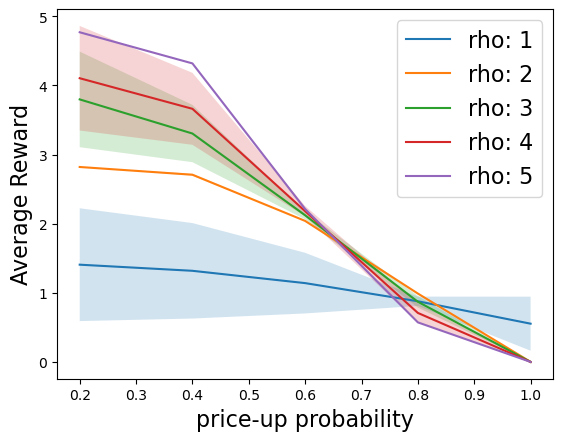

In [22]:
import time
T1 = 100
H = 20
beta = 0.1
lam = 1
rho_list = [1, 2, 3, 4, 5]
p0 = 0.5
d = 30
replication = 3
algorithm_dict = {'LSVI_LCB': LSVI_LCB, 'DR_LSVI_LCB': DR_LSVI_LCB, 'SRPVI_TV': SRPVI_TV, 'SRPVI_KL': SRPVI_KL}
algorithm = SRPVI_TV
for rho in rho_list:
    agent_dic = []

    for rep in range(replication):
        Offline_Dataset = Offline_Dataset_Collection(T1, American_put_option(p0, d, seed=rep))
        #start_time = time.time()
        agent = train_agent_once(Offline_Dataset, algorithm, p0, d, H, T1, beta, lam, rho)
        end_time = time.time()
        #print(f'time: {end_time - start_time}')
        agent_dic.append(agent)

    PROB = [x / 5 for x in range(1,6)]
    T2 = 100
    R_mean, R_std = test_agent(agent_dic, replication, PROB, d, H, T2)
    print(R_mean, R_std)
    plt.plot(PROB, R_mean, label = f'rho: {rho}')
    plt.fill_between(PROB, np.array(R_mean) - np.array(R_std), np.array(R_mean) + np.array(R_std), alpha=0.2)

plt.legend(fontsize=16)
plt.xlabel('price-up probability', size=16)
plt.ylabel('Average Reward', size=16)
plt.savefig(f'APO_{p0}_{d}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

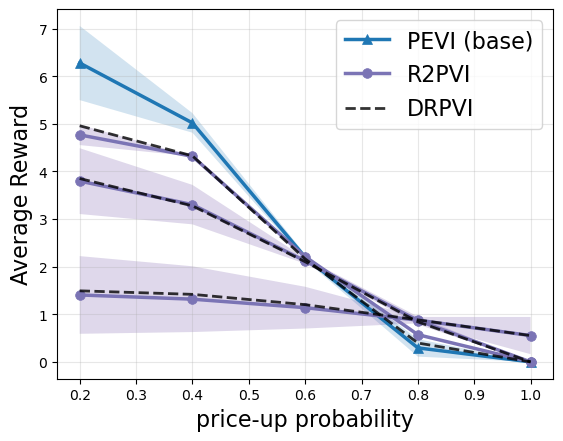

In [70]:
R_base = [6.278773024696449, 5.0204468548388705, 2.199472454712436, 0.2948691639941223, 0.0]
R_std = [0.7789182428280365, 0.2057549512813446, 0.05911852486285891, 0.1838598443965055, 0.0]

RR_mean= [3.7980070734818185, 3.304217697234902, 2.1211851624077616, 0.8699031046731015, 0.0]
RR_std = [0.6914276480050362, 0.41453012595358757, 0.0583083174223299, 0.08413619688238554, 0.0]

RR_mean_2= [4.769117715933979, 4.318642274276567, 2.2114708043136067, 0.5719729398665501, 0.0]
RR_std_2 = [0.2140891964467532, 0.0, 0.018281783928935275, 0.0, 0.0]

RR_mean_3= [1.4068183537971073, 1.318246740501848, 1.1400559919429347, 0.8774268460568008, 0.5531866353161755]
RR_std_3 = [0.8160555324537482, 0.6907963556903274, 0.438796582388898, 0.06738288240226532, 0.3911620210938374]

DR_base = [3.852117826555123, 3.277984270898005, 2.104743595879347, 0.8413825138713692, 0.0]
DR_std = [0.6058870296013824, 0.3776494567797384, 0.07014394890453865, 0.08468574862480734, 0.0]

DR_base_2 = [4.960120319877422, 4.328204800757518, 2.1639868747468722, 0.39703148840676256, 0.0]
DR_std_2 = [1.3203228118914394, 0.8672834277561821, 0.02022924324574113, 0.3305749945988175, 0.0]

DR_base_3 = [1.4932468740739642, 1.4193946072798809, 1.203069435332513, 0.8828165204463968, 0.5531866353161755]
DR_std_3 = [0.9382839180051171, 0.8338410406929282, 0.5279110486422688, 0.07500503302080701, 0.3911620210938374]
plt.plot(PROB, R_base, linewidth=2.5, markersize=7, marker = '^', markeredgewidth=0.5, label = f'PEVI (base)')
plt.fill_between(PROB, np.array(R_base) - np.array(R_std), np.array(R_base) + np.array(R_std), alpha=0.2)

colors = plt.cm.Purples(np.linspace(0.2, 0.8, 5))

plt.plot(PROB, RR_mean, linewidth=2.5, markersize=7, marker = 'o', markeredgewidth=0.5, color = colors[3], label = r'R2PVI')
plt.fill_between(PROB, np.array(RR_mean) - np.array(RR_std), np.array(RR_mean) + np.array(RR_std), alpha=0.2, color = colors[4], edgecolor='none')

plt.plot(PROB, RR_mean_2, linewidth=2.5, markersize=7, marker = 'o', markeredgewidth=0.5,color = colors[3])
plt.fill_between(PROB, np.array(RR_mean_2) - np.array(RR_std_2), np.array(RR_mean_2) + np.array(RR_std_2), alpha=0.2, color = colors[4], edgecolor='none')

plt.plot(PROB, RR_mean_3, linewidth=2.5, markersize=7, marker = 'o', markeredgewidth=0.5,color = colors[3])
plt.fill_between(PROB, np.array(RR_mean_3) - np.array(RR_std_3), np.array(RR_mean_3) + np.array(RR_std_3), alpha=0.2, color = colors[4], edgecolor='none')

plt.plot(PROB, DR_base, linewidth=2, markersize=7, linestyle='--', color = 'black', label = r'DRPVI', alpha = 0.8)
#plt.fill_between(PROB, np.array(DR_base) - np.array(DR_std), np.array(DR_base) + np.array(DR_std), alpha=0.2)

plt.plot(PROB, DR_base_2, linewidth=2, markersize=7, linestyle='--',color = 'black', alpha =0.8)
#plt.fill_between(PROB, np.array(DR_base_2) - np.array(DR_std_2), np.array(DR_base_2) + np.array(DR_std_2), alpha=0.2)

plt.plot(PROB, DR_base_3, linewidth=2, markersize=7, linestyle='--', color = 'black', alpha =0.8)
#plt.fill_between(PROB, np.array(DR_base_3) - np.array(DR_std_3), np.array(DR_base_3) + np.array(DR_std_3), alpha=0.2)


plt.grid(alpha = 0.3)
plt.legend(fontsize=16)
plt.xlabel('price-up probability', size=16)
plt.ylabel('Average Reward', size=16)
plt.savefig(f'1.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

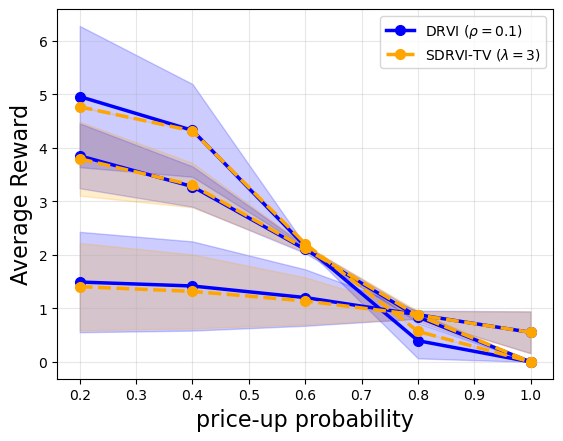

In [40]:
R_base = [6.278773024696449, 5.0204468548388705, 2.199472454712436, 0.2948691639941223, 0.0]
R_std = [0.7789182428280365, 0.2057549512813446, 0.05911852486285891, 0.1838598443965055, 0.0]

RR_mean= [3.7980070734818185, 3.304217697234902, 2.1211851624077616, 0.8699031046731015, 0.0]
RR_std = [0.6914276480050362, 0.41453012595358757, 0.0583083174223299, 0.08413619688238554, 0.0]

RR_mean_2= [4.769117715933979, 4.318642274276567, 2.2114708043136067, 0.5719729398665501, 0.0]
RR_std_2 = [0.009140891964467532, 0.0, 0.018281783928935275, 0.0, 0.0]

RR_mean_3= [1.4068183537971073, 1.318246740501848, 1.1400559919429347, 0.8774268460568008, 0.5531866353161755]
RR_std_3 = [0.8160555324537482, 0.6907963556903274, 0.438796582388898, 0.06738288240226532, 0.3911620210938374]

DR_base = [3.852117826555123, 3.277984270898005, 2.104743595879347, 0.8413825138713692, 0.0]
DR_std = [0.6058870296013824, 0.3776494567797384, 0.07014394890453865, 0.08468574862480734, 0.0]

DR_base_2 = [4.960120319877422, 4.328204800757518, 2.1639868747468722, 0.39703148840676256, 0.0]
DR_std_2 = [1.3203228118914394, 0.8672834277561821, 0.02022924324574113, 0.3305749945988175, 0.0]

DR_base_3 = [1.4932468740739642, 1.4193946072798809, 1.203069435332513, 0.8828165204463968, 0.5531866353161755]
DR_std_3 = [0.9382839180051171, 0.8338410406929282, 0.5279110486422688, 0.07500503302080701, 0.3911620210938374]
plt.plot(PROB, DR_base, linewidth=2.5, markersize=7, marker='o', color='blue', label=r'DRVI ($\rho = 0.1$)')
plt.fill_between(PROB, np.array(DR_base) - np.array(DR_std), np.array(DR_base) + np.array(DR_std), alpha=0.2, color='blue')

plt.plot(PROB, DR_base_2, linewidth=2.5, markersize=7, marker='o', color='blue')
plt.fill_between(PROB, np.array(DR_base_2) - np.array(DR_std_2), np.array(DR_base_2) + np.array(DR_std_2), alpha=0.2, color='blue')

plt.plot(PROB, DR_base_3, linewidth=2.5, markersize=7, marker='o', color='blue')
plt.fill_between(PROB, np.array(DR_base_3) - np.array(DR_std_3), np.array(DR_base_3) + np.array(DR_std_3), alpha=0.2, color='blue')

# 绘制第二组线
plt.plot(PROB, RR_mean, linewidth=2.5, markersize=7, marker='o', linestyle='--', color='orange', label=r'SDRVI-TV ($\lambda = 3$)')
plt.fill_between(PROB, np.array(RR_mean) - np.array(RR_std), np.array(RR_mean) + np.array(RR_std), alpha=0.2, color='orange')

plt.plot(PROB, RR_mean_2, linewidth=2.5, markersize=7, marker='o', linestyle='--', color='orange')
plt.fill_between(PROB, np.array(RR_mean_2) - np.array(RR_std_2), np.array(RR_mean_2) + np.array(RR_std_2), alpha=0.2, color='orange')

plt.plot(PROB, RR_mean_3, linewidth=2.5, markersize=7, marker='o', linestyle='--', color='orange')
plt.fill_between(PROB, np.array(RR_mean_3) - np.array(RR_std_3), np.array(RR_mean_3) + np.array(RR_std_3), alpha=0.2, color='orange')
plt.grid(alpha = 0.3)
plt.legend()
plt.xlabel('price-up probability', size=16)
plt.ylabel('Average Reward', size=16)
plt.savefig(f'1.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

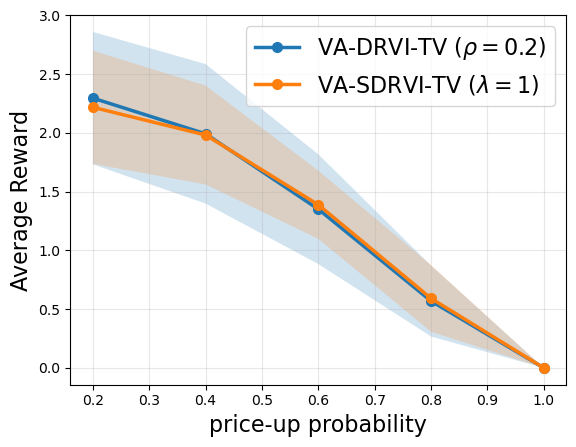

In [81]:
R1 = [2.296294318949237, 1.9922957641430117, 1.3507368446625814, 0.5687832556897546, 0.0]
R_std = [0.5636594074564342, 0.5938034987296786, 0.4671581058523608, 0.30150702758236114, 0.0]
R_2 = [2.2184871774693207, 1.982405729906309, 1.388182640938809, 0.5914758674615203, 0.0]
R_2std = [0.48161858757018616, 0.4207036224782811, 0.29009492171907864, 0.28388833119104995, 0.0]

plt.plot(PROB, R1, linewidth=2.5, markersize=7, marker = 'o', label = r'VA-DRVI-TV ($\rho = 0.2$)')
plt.fill_between(PROB, np.array(R1) - np.array(R_std), np.array(R1) + np.array(R_std), alpha=0.2)

plt.plot(PROB, R_2, linewidth=2.5, markersize=7, marker = 'o', label = r'VA-SDRVI-TV ($\lambda = 1$)')
plt.fill_between(PROB, np.array(R_2) - np.array(R_2std), np.array(R_2) + np.array(R_2std), alpha=0.2)

plt.grid(alpha = 0.3)
plt.legend(fontsize=16)
plt.xlabel('price-up probability', size=16)
plt.ylabel('Average Reward', size=16)
plt.savefig(f'2.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)